In [29]:
import xgboost

print(xgboost.__version__)

0.90


# Python Native XGboost

In [30]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Load xgboost (Python Native)
import xgboost as xgb
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')

In [31]:
# Load Wisconsin cancer dataset
dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [32]:
# Malignant = 0, Benign = 1
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [33]:
# Seperate features and labels
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]

# Split 80% train dataset and 20% test dataset
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2)

# Split 90% train dataset and 10% validation dataset from train dataset
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1)

**Convert datasets into DMatrix**
* Python native XGboost requires DMatrix for its dataset
* numpy array, DataFrame -> DMatrix

In [34]:
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test , label=y_test)

In [35]:
# Set hyper parameters
params = {'max_depth':3,
          'eta': 0.05, #learning rate
          'objective': 'binary:logistic', #sigmoid
          'eval_metric': 'logloss'} #loss function
rounds = 400 #epochs

In [36]:
# Designate evaluation dataset for early stopping
eval_list = [(dtr,'train'), (dval, 'eval')]

# Start training
xgb_model = xgb.train(params = params, dtrain=dtr, num_boost_round=rounds,
                      early_stopping_rounds=30, evals=eval_list)

[0]	train-logloss:0.651958	eval-logloss:0.654017
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 30 rounds.
[1]	train-logloss:0.614623	eval-logloss:0.618124
[2]	train-logloss:0.578729	eval-logloss:0.5843
[3]	train-logloss:0.547513	eval-logloss:0.554856
[4]	train-logloss:0.517118	eval-logloss:0.528129
[5]	train-logloss:0.490689	eval-logloss:0.502908
[6]	train-logloss:0.464664	eval-logloss:0.479478
[7]	train-logloss:0.441122	eval-logloss:0.457733
[8]	train-logloss:0.419304	eval-logloss:0.438096
[9]	train-logloss:0.398604	eval-logloss:0.419474
[10]	train-logloss:0.380411	eval-logloss:0.403171
[11]	train-logloss:0.362763	eval-logloss:0.387591
[12]	train-logloss:0.345586	eval-logloss:0.372648
[13]	train-logloss:0.330215	eval-logloss:0.358395
[14]	train-logloss:0.31564	eval-logloss:0.344863
[15]	train-logloss:0.302165	eval-logloss:0.332117
[16]	train-logloss:0.28897	eval-logloss:0.32085
[17]	train-loglo

**Construct evaluation function**

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def evaluate_model(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('Confusion Matrix')
    print(confusion)
    print(': Accuracy{0:.4f}, Precision: {1:.4f}, Recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

**Predict with test data**

In [38]:
# Python native xgboost returns prediction probability values
pred_probs = xgb_model.predict(dtest) #dtest = DMatrix

# Convert prediction probability to binary result
preds = [1 if x > 0.5 else 0 for x in pred_probs]

**Evaluate**

In [39]:
evaluate_model(y_test, preds, pred_probs)

Confusion Matrix
[[40  2]
 [ 2 70]]
: Accuracy0.9649, Precision: 0.9722, Recall: 0.9722,    F1: 0.9722, AUC:0.9851


**Visualize Feature Importance**

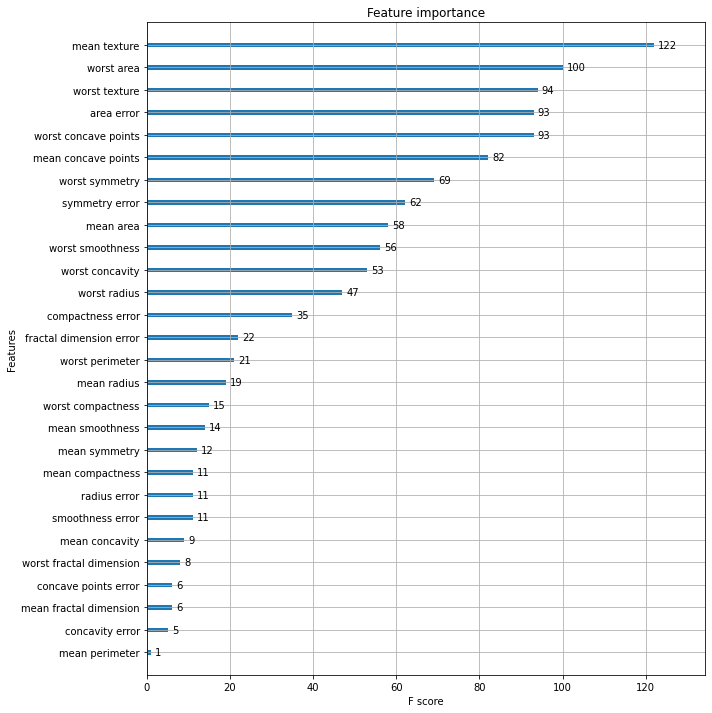

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot_importance function requires 'ax'
# F score: How often the feature is used for classification in the decision tree
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

# Scikit-learn Wrapper XGBoost

In [41]:
from xgboost import XGBClassifier

# Train without early stopping

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metrics='logloss')
xgb_wrapper.fit(X_train, y_train, verbose=True)

# Predict

preds2 = xgb_wrapper.predict(X_test)
pred_proba2 = xgb_wrapper.predict_proba(X_test)[:,1] # Extract only postive probability


In [42]:
# Evaluate
evaluate_model(y_test, preds2, pred_proba2)

Confusion Matrix
[[40  2]
 [ 2 70]]
: Accuracy0.9649, Precision: 0.9722, Recall: 0.9722,    F1: 0.9722, AUC:0.9854


In [43]:
# Train with early stopping
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metrics='logloss')
evals = [(X_val,y_val)]
xgb_wrapper.fit(X_tr,y_tr, early_stopping_rounds=10, eval_metric='logloss',
                eval_set=evals, verbose=True)

[0]	validation_0-logloss:0.654017
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.618124
[2]	validation_0-logloss:0.5843
[3]	validation_0-logloss:0.554856
[4]	validation_0-logloss:0.528129
[5]	validation_0-logloss:0.502908
[6]	validation_0-logloss:0.479478
[7]	validation_0-logloss:0.457733
[8]	validation_0-logloss:0.438096
[9]	validation_0-logloss:0.419474
[10]	validation_0-logloss:0.403171
[11]	validation_0-logloss:0.387591
[12]	validation_0-logloss:0.372648
[13]	validation_0-logloss:0.358395
[14]	validation_0-logloss:0.344863
[15]	validation_0-logloss:0.332117
[16]	validation_0-logloss:0.32085
[17]	validation_0-logloss:0.308368
[18]	validation_0-logloss:0.298545
[19]	validation_0-logloss:0.288745
[20]	validation_0-logloss:0.277097
[21]	validation_0-logloss:0.266144
[22]	validation_0-logloss:0.25629
[23]	validation_0-logloss:0.249536
[24]	validation_0-logloss:0.24038
[25]	validation_0-logloss:0.232048
[26]	validation_0-logloss:0.226043
[2

XGBClassifier(eval_metrics='logloss', learning_rate=0.05, n_estimators=400)

In [44]:
# Predict
ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [45]:
# Evaluate
evaluate_model(y_test , ws10_preds, ws10_pred_proba)

Confusion Matrix
[[40  2]
 [ 2 70]]
: Accuracy0.9649, Precision: 0.9722, Recall: 0.9722,    F1: 0.9722, AUC:0.9851


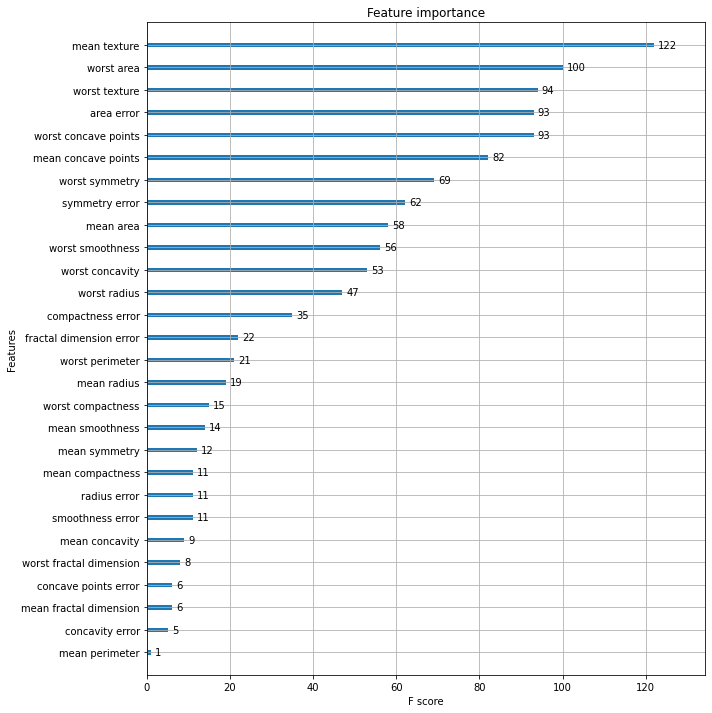

In [46]:
# Visualize feature importance
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
# Same with python native XGboost
plot_importance(xgb_wrapper, ax=ax)